In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import LSTM
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, Embedding
from tensorflow.keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.layers import Bidirectional
from sklearn.ensemble import RandomForestClassifier

In [55]:
train = pd.read_csv("preprocessed_train_data.csv", index_col = 0)
test = pd.read_csv("preprocessed_test_data.csv", index_col = 0)
test_result = pd.read_csv("NewCheat.csv", index_col = 0)

trained_tweets = train['keyword']+train['text']
test_tweets = test['keyword']+test['text']


In [56]:
state = 12  
test_size = 0.30
  
X_train, X_test, y_train, y_test = train_test_split(trained_tweets, train['target'],  
    test_size=test_size, random_state=state)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

word_vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 3),
    lowercase=True,
    min_df=5,
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    stop_words='english',
    ngram_range=(3, 6),
    lowercase=True,
    min_df=5,
    max_features=50000)

vectorizer = FeatureUnion([('word_vectorizer', word_vectorizer),  ('char_vectorizer', char_vectorizer)])
vectorizer.fit(X_train)

X_train_vectors = vectorizer.transform(X_train).toarray()
X_test_vectors = vectorizer.transform(X_test).toarray()
print(X_train_vectors.shape, X_test_vectors.shape)

/home/neptune/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


(5329, 44132) (2284, 44132)


In [8]:
gb_clf = GradientBoostingClassifier(n_estimators=120, learning_rate=0.075, max_features=100, max_depth=25, random_state=0)
gb_clf.fit(X_train_vectors, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=25,
                           max_features=100, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [45]:
cv = CountVectorizer()
cv_x_train = cv.fit_transform(X_train).toarray()
cv_x_test = cv.transform(X_test).toarray()
cv_test = cv.transform(test_tweets).toarray()
clf_nb = MultinomialNB()
clf_nb.fit(cv_x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_vectors, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
## Tokenize the sentences
max_features=50000
maxlen=25
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.tolist())
X_train = tokenizer.texts_to_sequences(X_train.tolist())
X_test = tokenizer.texts_to_sequences(X_test.tolist())
x_test_nn = tokenizer.texts_to_sequences(test_tweets.tolist())

## Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
x_test_nn = pad_sequences(x_test_nn, maxlen=maxlen)

vocab_dim = X_train.max() + 1
embed_dim = int(np.sqrt(vocab_dim))
print(vocab_dim, embed_dim)
model = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    SimpleRNN(units=embed_dim, return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True, validation_data=(X_test, y_test), shuffle=True
)


9695 98
Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 2s 325us/sample - loss: 0.6015 - acc: 0.6628 - val_loss: 0.4877 - val_acc: 0.7859
Epoch 2/5
5329/5329 [==============================] - 1s 225us/sample - loss: 0.2507 - acc: 0.9060 - val_loss: 0.5983 - val_acc: 0.7412
Epoch 3/5
5329/5329 [==============================] - 1s 222us/sample - loss: 0.1145 - acc: 0.9645 - val_loss: 0.6318 - val_acc: 0.7666
Epoch 4/5
5329/5329 [==============================] - 1s 280us/sample - loss: 0.0793 - acc: 0.9767 - val_loss: 0.6287 - val_acc: 0.7644
Epoch 5/5
5329/5329 [==============================] - 1s 223us/sample - loss: 0.0666 - acc: 0.9780 - val_loss: 0.6888 - val_acc: 0.7408


In [58]:
bi = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    Bidirectional(SimpleRNN(units=embed_dim, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
bi.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True, validation_data=(X_test, y_test), shuffle=True
)

Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 1s 220us/sample - loss: 0.0587 - acc: 0.9805 - val_loss: 0.6962 - val_acc: 0.7478
Epoch 2/5
5329/5329 [==============================] - 1s 221us/sample - loss: 0.0545 - acc: 0.9814 - val_loss: 0.7239 - val_acc: 0.7145
Epoch 3/5
5329/5329 [==============================] - 1s 234us/sample - loss: 0.0472 - acc: 0.9825 - val_loss: 0.7519 - val_acc: 0.7281
Epoch 4/5
5329/5329 [==============================] - 1s 220us/sample - loss: 0.0413 - acc: 0.9837 - val_loss: 0.7208 - val_acc: 0.7456
Epoch 5/5
5329/5329 [==============================] - 1s 222us/sample - loss: 0.0367 - acc: 0.9837 - val_loss: 0.7947 - val_acc: 0.7377


In [59]:
lstm = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    LSTM(units=embed_dim, return_sequences=False),
    Dense(1, activation='sigmoid')
])
lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
lstm.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True, validation_data=(X_test, y_test), shuffle=True
)

Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 4s 752us/sample - loss: 0.5685 - acc: 0.7013 - val_loss: 0.4729 - val_acc: 0.7793
Epoch 2/5
5329/5329 [==============================] - 3s 581us/sample - loss: 0.3133 - acc: 0.8722 - val_loss: 0.4874 - val_acc: 0.7916
Epoch 3/5
5329/5329 [==============================] - 4s 685us/sample - loss: 0.1937 - acc: 0.9298 - val_loss: 0.5643 - val_acc: 0.7728
Epoch 4/5
5329/5329 [==============================] - 3s 533us/sample - loss: 0.1262 - acc: 0.9572 - val_loss: 0.6748 - val_acc: 0.7592
Epoch 5/5
5329/5329 [==============================] - 4s 666us/sample - loss: 0.0975 - acc: 0.9673 - val_loss: 0.8030 - val_acc: 0.7715


In [14]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(cv_x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [15]:
linear = SVC(kernel='linear', probability = True)
linear.fit(X_train_vectors, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [16]:
rf = RandomForestClassifier(n_estimators=130, 
                               random_state=50, 
                               max_features = 50,
                               max_depth = 200,
                               n_jobs=-1, verbose = 1, warm_start = True)
rf.fit(X_train_vectors, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   15.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=True)

In [60]:
x_test = vectorizer.transform(test_tweets).toarray()
y_test = test_result['target']

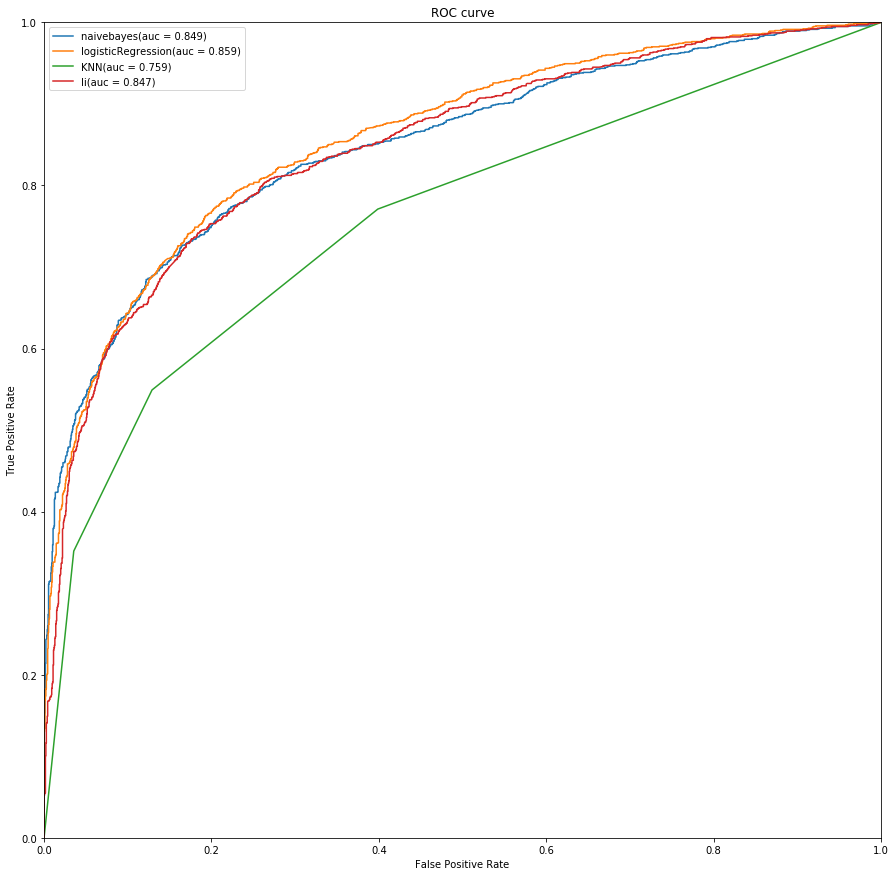

In [48]:
from sklearn.metrics import roc_curve, auc

y_nb  = clf_nb.predict_proba(cv_test)
curve_nb   = roc_curve(y_test, y_nb[:, 1])
auc_nb  = auc(curve_nb[0], curve_nb[1])

y_lr  = logisticRegr.predict_proba(x_test)
curve_lr   = roc_curve(y_test, y_lr[:, 1])
auc_lr  = auc(curve_lr[0], curve_lr[1])

y_knn  = classifier.predict_proba(cv_test)
curve_knn   = roc_curve(y_test, y_knn[:, 1])
auc_knn  = auc(curve_knn[0], curve_knn[1])

y_li = linear.predict_proba(x_test)
curve_li = roc_curve(y_test, y_li[:,1])
auc_li = auc(curve_li[0], curve_li[1])



plt.figure(figsize = (15,15))
plt.plot(curve_nb[0], curve_nb[1], label='naivebayes(auc = %0.3f)' % auc_nb)
plt.plot(curve_lr[0], curve_lr[1], label='logisticRegression(auc = %0.3f)' % auc_lr)
plt.plot(curve_knn[0], curve_knn[1], label='KNN(auc = %0.3f)' % auc_knn)
plt.plot(curve_li[0], curve_li[1], label='li(auc = %0.3f)' % auc_li)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.3s finished


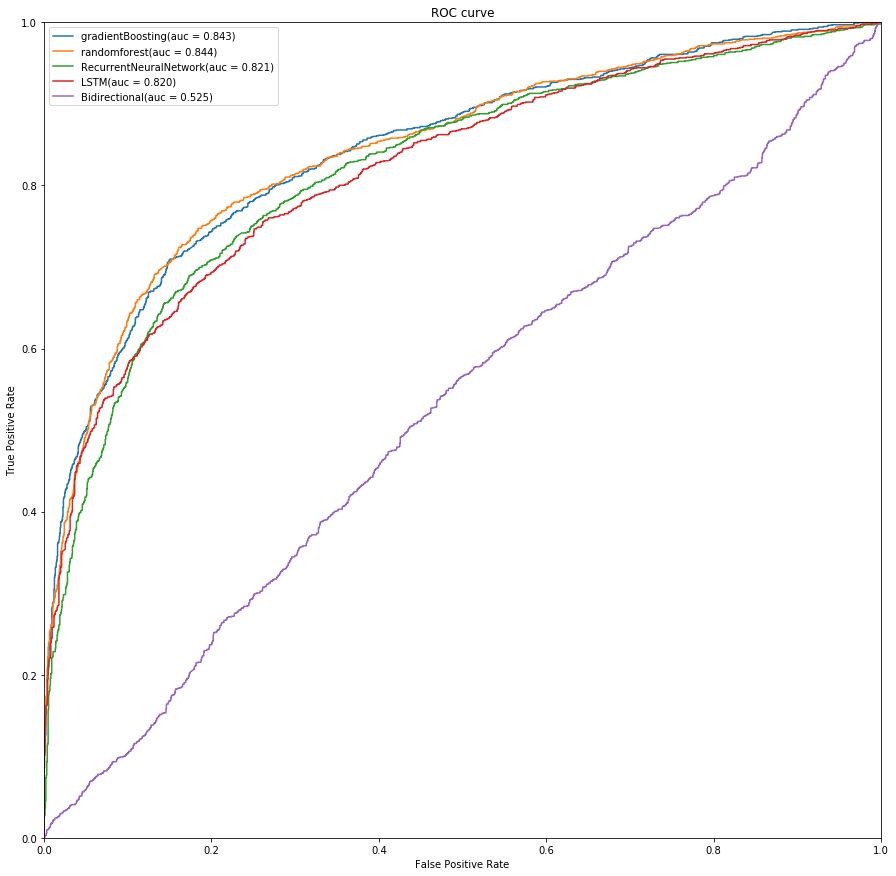

In [62]:
y_gb  = gb_clf.predict_proba(x_test)
curve_gb   = roc_curve(y_test, y_gb[:, 1])
auc_gb   = auc(curve_gb[0], curve_gb[1])

y_rf  = rf.predict_proba(x_test)
curve_rf   = roc_curve(y_test, y_rf[:, 1])
auc_rf   = auc(curve_rf[0], curve_rf[1])

y_rnn  = model.predict_proba(x_test_nn)
curve_rnn   = roc_curve(y_test, y_rnn)
auc_rnn  = auc(curve_rnn[0], curve_rnn[1])

y_lstm  = lstm.predict_proba(x_test_nn)
curve_lstm   = roc_curve(y_test, y_lstm)
auc_lstm  = auc(curve_lstm[0], curve_lstm[1])

y_bi  = bi.predict_proba(x_test_nn)
curve_bi   = roc_curve(y_test, y_bi)
auc_bi  = auc(curve_bi[0], curve_bi[1])

plt.figure(figsize = (15,15))

plt.plot(curve_gb[0], curve_gb[1], label='gradientBoosting(auc = %0.3f)' % auc_gb)
plt.plot(curve_rf[0], curve_rf[1], label='randomforest(auc = %0.3f)' % auc_rf)
plt.plot(curve_rnn[0], curve_rnn[1], label='RecurrentNeuralNetwork(auc = %0.3f)' % auc_rnn)
plt.plot(curve_lstm[0], curve_lstm[1], label='LSTM(auc = %0.3f)' % auc_lstm)
plt.plot(curve_bi[0], curve_bi[1], label='Bidirectional(auc = %0.3f)' % auc_bi)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();